# GNN for Link + Vote Prediction with sliding window training

This notebook trains a **Hierarchical Graph Neural Network** to predict link existance and vote polarity simultaneously.

In this variant we explore the **sliding window training approach**, which consists in:

- firstly consider a window of fixed size W
- split the window in training, validation and test sets and perform training and evaluation
- then move the window by a step size S
- this approach until now **do not** use the concept of continual learning


## Setup

In [17]:
# Import standard libraries
import sys
from pathlib import Path
from collections import Counter
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Data handling
import pandas as pd
# Computations
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import LinkNeighborLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
# Import this project modules
REPO_ROOT = Path('.').resolve()
if REPO_ROOT not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
from dataset import WikiRfAPreprocessor, CandidateCentricSampler, train_val_test_split_by_date, extract_node_features
from utility import sum_months, analyze_split_statistics
from training import eval_hierarchical, train_hierarchical

## Data loading and filtering

Load and parse the wiki-RfA dataset from the .txt.gz file into (SRC, TGT, VOT, DAT) tuples.

Invalid samples are filtered out:

- empty date
- incorrect date
- self votes

In [18]:
preprocessed_RfA = WikiRfAPreprocessor("dataset/wiki-RfA.txt.gz")
preprocessed_RfA.load(verbose=True)

Loading dataset from dataset/wiki-RfA.txt.gz...
Raw line 0: SRC:Steel1943
Raw line 1: TGT:BDD
Raw line 2: VOT:1
Raw line 3: RES:1
Raw line 4: YEA:2013
Raw line 5: DAT:23:13, 19 April 2013
Raw line 6: TXT:'''Support''' as co-nom.
Raw line 7: 
Raw line 8: SRC:Cuchullain
Raw line 9: TGT:BDD

------- Dataset Loaded -------
Total valid samples loaded: 188816
Example sample (SRC, TGT, VOT, DATE): ('Steel1943', 'BDD', 1, 20130419)

Discarded edges breakdown:
  EMPTY_ERROR: 9367
    Skipped edge: ('', 'Jason Quinn', '')
    Skipped edge: ('', 'Jason Quinn', '')
    Skipped edge: ('', 'Legoktm', '')
    Skipped edge: ('Majoreditor', 'Lord Roem', '')
  SELF_LOOP: 88
    Skipped edge: ('Ryan Vesey', 'Ryan Vesey', '17:07, 4 July 2012')
    Skipped edge: ('Anomie', 'Anomie', '16:29, 25 September 2011')
    Skipped edge: ('Spongefrog', 'Spongefrog', '18:33, 28 September 2011')
    Skipped edge: ('Tarheel95', 'Tarheel95', '00:46, 8 December 2011')
  ERROR_OTHERS: 4
    Skipped edge: ('JonasEncycloped

## User encoding

Encode Wikipedia usernames into contiguous integer node IDs.

In [19]:
# Encode users as numerical IDs
users = list(set([s[0] for s in preprocessed_RfA.samples] + [s[1] for s in preprocessed_RfA.samples]))
encoder = LabelEncoder()
user_ids = encoder.fit_transform(users)
user_map = dict(zip(users, user_ids))

print(f"Unique users: {len(users)}")
print(list(user_map.items())[:10])

Unique users: 11128
[('Abyssal', np.int64(226)), ('WAvegetarian', np.int64(10228)), ('Astroview120mm', np.int64(836)), ('Jim Sweeney', np.int64(4875)), ('Agne27', np.int64(326)), ('Wcreed88', np.int64(10307)), ('WheezyF', np.int64(10360)), ('Surajt88', np.int64(9214)), ('Smashville', np.int64(8814)), ('GoldDragon', np.int64(3843))]


In [20]:
# Dataset build (edge list + label)
X = []
y = []
dates = []

for src, tgt, vot, dat in preprocessed_RfA.samples:
    X.append([user_map[src], user_map[tgt]])
    y.append(vot)
    dates.append(dat)
        
X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)
dates = np.array(dates)

# labels for positives: {-1,0,1} -> {1,2,3}
y_pos = y + 2
print("Positive edges:", X.size(0))

Positive edges: 188816


## Generate windows

In [21]:
def get_sliding_windows(X: torch.Tensor, y: torch.Tensor, dates: np.ndarray, window_size_months=36, step_size_months=6, val_months=6, test_months=6):
    """
    Generate time-based train/val/test splits for each window.
    Args:
        X (torch.Tensor): Edge list tensor of shape (num_edges, 2).
        y (torch.Tensor): Labels tensor of shape (num_edges,).
        dates (np.ndarray): Array of dates corresponding to each edge.
        window_size_months (int): Size of each time window in months.
        step_size_months (int): Step size to move the window in months.
        val_months (int): Number of months for the validation set.
        test_months (int): Number of months for the test set.
    Yields:
        Tuples of (X_train, y_train, dates_train, X_val, y_val, dates_val, X_test, y_test, dates_test) for each time window.
    """
    current_start = min(dates)

    while True:
        current_end = sum_months(current_start, window_size_months)
        
        if current_end > max(dates):
            print("Reached the end of the date range. Discarded window:", current_start, "->", current_end)
            break
        
        # Extract the window
        mask_window = (dates >= current_start) & (dates < current_end)
        # If the window is empty, skip it
        if not np.any(mask_window):
            current_start = sum_months(current_start, step_size_months)
            continue

        # Internal splitting
        yield train_val_test_split_by_date(
            X[mask_window],
            y[mask_window],
            dates[mask_window],
            val_months=val_months,
            test_months=test_months
        )
        
        # Go to the next window
        current_start = sum_months(current_start, step_size_months)

def get_increasing_windows(X: torch.Tensor, y: torch.Tensor, dates: np.ndarray, window_size_months=24, val_months=6, test_months=6):
    """
    Generate time-based train/val/test splits for each increasing window.
    Args:
        X (torch.Tensor): Edge list tensor of shape (num_edges, 2).
        y (torch.Tensor): Labels tensor of shape (num_edges,).
        dates (np.ndarray): Array of dates corresponding to each edge.
        window_size_months (int): Size of first time window in months.
        val_months (int): Number of months for the validation set.
        test_months (int): Number of months for the test set.
    Yields:
        Tuples of (X_train, y_train, dates_train, X_val, y_val, dates_val, X_test, y_test, dates_test) for each time window.
    """
    current_start = min(dates)

    while True:
        current_end = sum_months(current_start, window_size_months)

        if current_end > max(dates):
            print("Reached the end of the date range. Discarded window:", current_start, "->", current_end)
            break
        
        # Extract the window
        mask_window = (dates < current_end)
        # If the window is empty, skip it
        if not np.any(mask_window):
            current_end = sum_months(current_end, val_months + test_months)
            continue

        # Internal splitting
        yield train_val_test_split_by_date(
            X[mask_window],
            y[mask_window],
            dates[mask_window],
            val_months=val_months,
            test_months=test_months
        )

Reached the end of the date range. Discarded window: 20100816 -> 20130816
    Total_Size        Train_Interval          Val_Interval         Test_Interval
0        52168  (20030816, 20050814)  (20050815, 20060214)  (20060215, 20060815)
1        71369  (20040216, 20060214)  (20060215, 20060814)  (20060815, 20070215)
2        88760  (20040816, 20060814)  (20060815, 20070214)  (20070215, 20070815)
3       106034  (20050216, 20070214)  (20070215, 20070814)  (20070815, 20080215)
4       117673  (20050816, 20070814)  (20070815, 20080214)  (20080215, 20080815)
5       110467  (20060216, 20080214)  (20080215, 20080814)  (20080815, 20090215)
6        96891  (20060816, 20080814)  (20080815, 20090214)  (20090215, 20090815)
7        87371  (20070216, 20090214)  (20090215, 20090814)  (20090815, 20100215)
8        74046  (20070816, 20090814)  (20090815, 20100214)  (20100215, 20100815)
9        60723  (20080216, 20100214)  (20100215, 20100814)  (20100815, 20110215)
10       49709  (20080816, 20100814

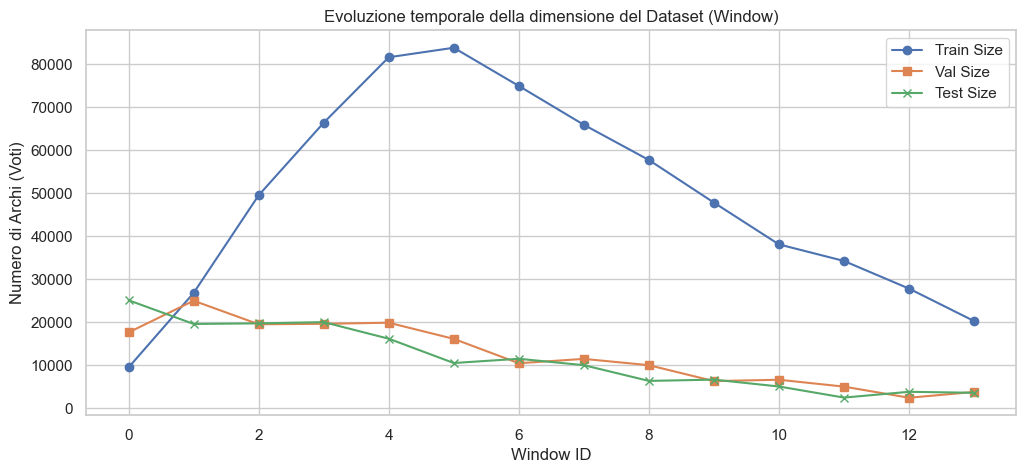

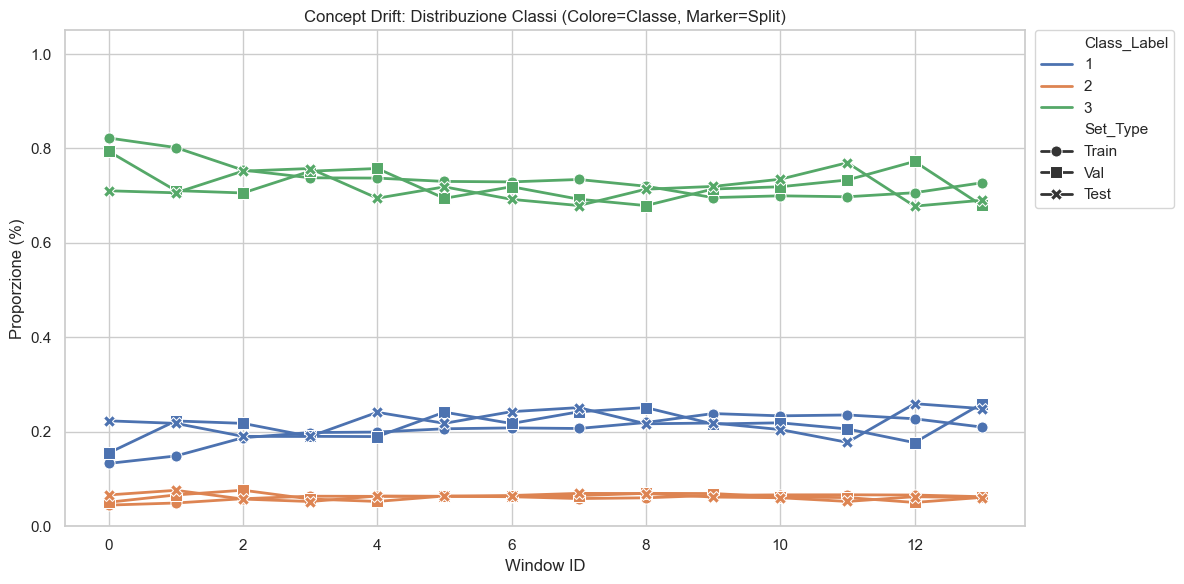

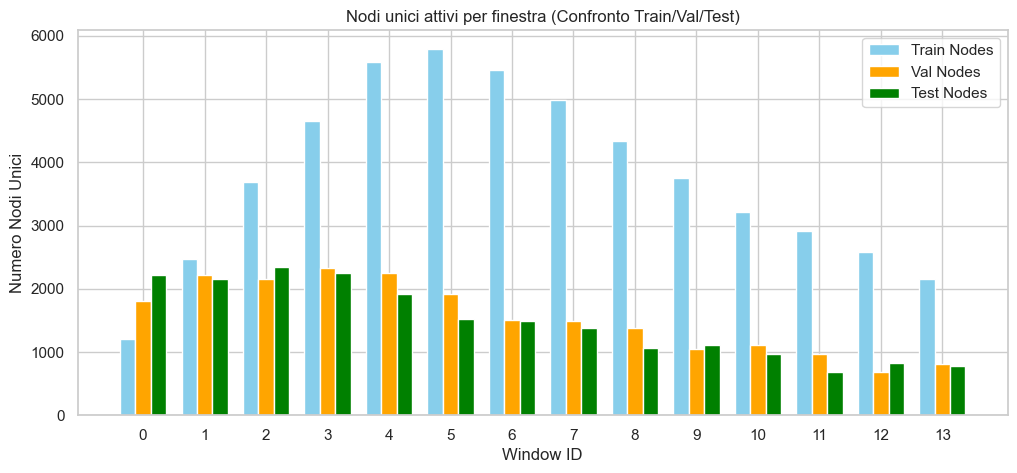

In [22]:
def analyze_windows(window_generator):
    """
    Consuma il generatore di finestre e calcola statistiche dettagliate.
    Args:
        window_generator: Il generatore di windows
    Returns:
        pd.DataFrame: DataFrame contenente le statistiche per ogni finestra.
    """
    stats_list = []
    
    for i, ((X_tr, y_tr, dates_tr), (X_va, y_va, dates_va), (X_te, y_te, dates_te)) in enumerate(window_generator):
        
        # Calcolo distribuzioni delle classi
        train_counts = Counter(y_tr.numpy())
        val_counts = Counter(y_va.numpy())
        test_counts = Counter(y_te.numpy())
        
        # Calcolo nodi unici attivi (Voters + Candidates)
        train_unique_nodes = len(np.unique(X_tr.numpy()))
        val_unique_nodes = len(np.unique(X_va.numpy()))
        test_unique_nodes = len(np.unique(X_te.numpy()))
        
        # Struttura dati per il DataFrame
        row = {
            'Window_ID': i,
            'Train_Size': len(y_tr),
            'Val_Size': len(y_va),
            'Test_Size': len(y_te),
            'Total_Size': len(y_tr) + len(y_va) + len(y_te),
            'Train_Interval': (min(dates_tr), max(dates_tr)),
            'Val_Interval': (min(dates_va), max(dates_va)),
            'Test_Interval': (min(dates_te), max(dates_te)),
            'Train_Unique_Nodes': train_unique_nodes,
            'Val_Unique_Nodes': val_unique_nodes,
            'Test_Unique_Nodes': test_unique_nodes,
            'Train_Ratio': len(y_tr) / (len(y_tr) +len(y_va) + len(y_te)),
            'Val_Ratio': len(y_va) / (len(y_tr) + len(y_va) + len(y_te)),
            'Test_Ratio': len(y_te) / (len(y_tr) + len(y_va) + len(y_te))
        }
        
        # Aggiungiamo le info sulle classi in colonne separate (es. Train_Class_0, Train_Class_1...)
        all_classes = set(list(train_counts.keys()) + list(val_counts.keys()) + list(test_counts.keys()))
        for cls in sorted(all_classes):
            row[f'Train_Class_{cls}'] = train_counts.get(cls, 0)
            row[f'Val_Class_{cls}'] = val_counts.get(cls, 0)
            row[f'Test_Class_{cls}'] = test_counts.get(cls, 0)
            
            # Calcoliamo anche la percentuale per vedere il drift
            row[f'Train_Perc_Class_{cls}'] = train_counts.get(cls, 0) / len(y_tr) if len(y_tr) > 0 else 0
            row[f'Val_Perc_Class_{cls}'] = val_counts.get(cls, 0) / len(y_va) if len(y_va) > 0 else 0
            row[f'Test_Perc_Class_{cls}'] = test_counts.get(cls, 0) / len(y_te) if len(y_te) > 0 else 0
            
        stats_list.append(row)

    df_stats = pd.DataFrame(stats_list)
    return df_stats

def plot_window_stats(df_stats):
    sns.set_theme(style="whitegrid")
    
    # --- 1. Plot Dimensione dei Dataset nel tempo ---
    plt.figure(figsize=(12, 5))
    plt.plot(df_stats['Window_ID'], df_stats['Train_Size'], label='Train Size', marker='o')
    plt.plot(df_stats['Window_ID'], df_stats['Val_Size'], label='Val Size', marker='s')
    plt.plot(df_stats['Window_ID'], df_stats['Test_Size'], label='Test Size', marker='x')
    plt.title('Evoluzione temporale della dimensione del Dataset (Window)')
    plt.xlabel('Window ID')
    plt.ylabel('Numero di Archi (Voti)')
    plt.legend()
    plt.show()
    
    # --- 2. Plot Distribuzione delle Classi (Concept Drift) ---
    perc_cols = [c for c in df_stats.columns if '_Perc_Class_' in c]
    
    if perc_cols:
        df_melted = df_stats.melt(id_vars='Window_ID', value_vars=perc_cols, 
                                  var_name='Variable', value_name='Percentage')
        
        # Funzione per estrarre Set e Classe dal nome della colonna
        def parse_col_name(name):
            parts = name.split('_Perc_Class_')
            return parts[0], parts[1]

        df_melted[['Set_Type', 'Class_Label']] = df_melted['Variable'].apply(
            lambda x: pd.Series(parse_col_name(x))
        )
        
        plt.figure(figsize=(12, 6))
        
        markers_map = {"Train": "o", "Val": "s", "Test": "X"}
        linestyles_map = {"Train": "", "Val": "", "Test": ""}         
        sns.lineplot(
            data=df_melted, 
            x='Window_ID', 
            y='Percentage', 
            hue='Class_Label',    # Stesso colore per la stessa classe
            style='Set_Type',     # Diverso simbolo per Train/Val/Test
            markers=markers_map,  # Mappatura personalizzata dei simboli
            dashes=False,         # Forza linee solide per tutti (la distinzione è nel marker)
            linewidth=2,
            markersize=8
        )
        plt.title('Concept Drift: Distribuzione Classi (Colore=Classe, Marker=Split)')
        plt.xlabel('Window ID')
        plt.ylabel('Proporzione (%)')
        plt.ylim(0, 1.05)
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
        plt.tight_layout()
        plt.show()
    
    # --- 3. Analisi Nodi Unici (Densità/Sparsità) ---
    plt.figure(figsize=(12, 5))
    bar_width = 0.25
    x = df_stats['Window_ID']
    plt.bar(x - bar_width, df_stats['Train_Unique_Nodes'], width=bar_width, label='Train Nodes', color='skyblue')
    plt.bar(x, df_stats['Val_Unique_Nodes'], width=bar_width, label='Val Nodes', color='orange')
    plt.bar(x + bar_width, df_stats['Test_Unique_Nodes'], width=bar_width, label='Test Nodes', color='green')
    plt.title('Nodi unici attivi per finestra (Confronto Train/Val/Test)')
    plt.xlabel('Window ID')
    plt.ylabel('Numero Nodi Unici')
    plt.xticks(x) # Assicura che ci sia un tick per ogni finestra
    plt.legend()
    plt.show()

# --- ESEMPIO DI UTILIZZO ---
# Nota: Ricrea il generatore perché i generatori si esauriscono una volta iterati!
windows_gen = get_sliding_windows(X, y_pos, dates)

df_results = analyze_windows(windows_gen)
pd.set_option('display.width', 100)
print(df_results[["Total_Size", "Train_Interval", "Val_Interval", "Test_Interval"]])
plot_window_stats(df_results)

## Model

In [23]:
class HierGNN(nn.Module):
    def __init__(self, feature_dim, emb_dim=64, hidden_dim=128, dropout=0.3):
        super().__init__()

        # # Learnable node ID embeddings (replaces one-hot)
        # self.node_emb = nn.Embedding(num_nodes, emb_dim)

        # Sostituiamo Embedding con un Linear layer per proiettare le feature
        self.node_emb = nn.Linear(feature_dim, emb_dim)

        # GraphSAGE encoder (2 message-passing layers)
        self.conv1 = SAGEConv(emb_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.dropout = dropout

        # Edge feature dimension: [h_s, h_t, |h_s-h_t|, h_s*h_t]
        edge_in = hidden_dim * 4

        # Head 1: link existence (NoVote vs Voted)
        self.link_mlp = nn.Sequential(
            nn.Linear(edge_in, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 2)
        )

        # Head 2: polarity (Oppose/Neutral/Support)
        self.pol_mlp = nn.Sequential(
            nn.Linear(edge_in, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 3)
        )

    def encode(self, batch):
        # Compute node embeddings on the sampled subgraph returned by LinkNeighborLoader
        x = self.node_emb(batch.x)

        x = self.conv1(x, batch.edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, batch.edge_index)
        x = F.relu(x)
        return x

    def edge_features(self, z, edge_label_index):
        # Build edge features from endpoint embeddings
        src, tgt = edge_label_index
        h_src, h_tgt = z[src], z[tgt]
        return torch.cat([h_src, h_tgt, torch.abs(h_src - h_tgt), h_src * h_tgt], dim=1)

    def forward(self, batch: Data):
        """
        Forward pass that returns both heads' logits for the batch edge_label_index.
        - link_logits: shape [B, 2]
        - pol_logits: shape [B, 3]
        """
        z = self.encode(batch)
        e = self.edge_features(z, batch.edge_label_index)
        link_logits = self.link_mlp(e)
        pol_logits  = self.pol_mlp(e)
        return link_logits, pol_logits

## Training loop

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # oppure 'mps' su Mac
num_users = len(user_map)

model = HierGNN(feature_dim=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

link_weights = torch.tensor([0.85, 1.22], dtype=torch.float).to(device)  # Example weights
pol_weights = torch.tensor([1.25, 2.32, 0.67], dtype=torch.float).to(device)  # Example weights

# Running message-passing graph built from accumulated TRAIN POSITIVE edges
train_edge_index = torch.empty((2, 0), dtype=torch.long)
dates_edge_index = torch.empty((0), dtype=torch.long)

for i, ((X_tr, y_tr, dates_tr), (X_va, y_va, dates_va), (X_te, y_te, dates_te)) in enumerate(get_sliding_windows(X, y_pos, dates)):
    print(f"\n--- Window {i} ---")

    # ---------------------------------------------------------
    # 1. Build the message-passing graph from TRAIN POSITIVE edges only
    # ---------------------------------------------------------
    # Append current window's positive training edges to the running edge_index
    train_edge_index = torch.cat([train_edge_index, X_tr.t().contiguous()], dim=1)  # [2, E_total_pos]
    dates_edge_index = torch.cat([dates_edge_index, torch.tensor(dates_tr, dtype=torch.long)])

    # Extract node features from training edges
    x_features = extract_node_features(
        edge_index=train_edge_index,
        edge_dates=dates_edge_index,
        num_nodes=num_users
    )

    data = Data(x=x_features, edge_index=train_edge_index)
    #analyze_split_statistics(X_tr, y_tr, X_va, y_va, X_te, y_te)

    # ---------------------------------------------------------
    # 2. Negative sampling
    # ---------------------------------------------------------
    neg_ratio = 2
    sampler = CandidateCentricSampler([X_tr, X_va, X_te])

    # Negatives for each split (no_vote = 0)
    X_tr_neg, y_tr_neg = sampler.sample_negatives(X_tr, num_users, ratio=neg_ratio, seed=42)
    X_val_neg, y_val_neg = sampler.sample_negatives(X_va, num_users, ratio=neg_ratio, seed=123)
    X_test_neg, y_test_neg = sampler.sample_negatives(X_te, num_users, ratio=neg_ratio, seed=999)

    # 4-class datasets: 0=no_vote, 1=oppose, 2=neutral, 3=support
    X_tr_4 = torch.cat([X_tr,  X_tr_neg],  dim=0)
    y_tr_4 = torch.cat([y_tr,  y_tr_neg],  dim=0)

    X_val_4 = torch.cat([X_va, X_val_neg], dim=0)
    y_val_4 = torch.cat([y_va, y_val_neg], dim=0)

    X_test_4 = torch.cat([X_te, X_test_neg], dim=0)
    y_test_4 = torch.cat([y_te, y_test_neg], dim=0)

    # ---------------------------------------------------------
    # 3. Weights per class
    # ---------------------------------------------------------
    # Link labels derived from 4-class labels: 0 -> NoVote, {1,2,3} -> Voted
    y_tr_link = (y_tr_4 != 0).long()
    link_counts = torch.bincount(y_tr_link, minlength=2).float()
    link_base_w = link_counts.sum() / (len(link_counts) * link_counts)
    alpha = 0.5
    link_weights = link_base_w.pow(alpha).to(device)

    # Polarity labels from positives only: {1,2,3} -> {0,1,2}
    y_tr_pol = (y_tr - 1).long()
    pol_counts = torch.bincount(y_tr_pol, minlength=3).float()
    pol_base_w = pol_counts.sum() / (len(pol_counts) * pol_counts)
    pol_weights = pol_base_w.pow(alpha).to(device)

    # ---------------------------------------------------------
    # 4. LinkNeighborLoader
    # ---------------------------------------------------------
    # Message passing happens on data.edge_index (TRAIN POS edges only)
    train_loader = LinkNeighborLoader(
        data=data,
        num_neighbors=[100, 50],
        edge_label_index=X_tr_4.t().contiguous(),
        edge_label=y_tr_4,
        batch_size=2048,
        shuffle=True
    )

    val_loader = LinkNeighborLoader(
        data=data,
        num_neighbors=[100, 50],
        edge_label_index=X_val_4.t().contiguous(),
        edge_label=y_val_4,
        batch_size=4096,
        shuffle=False
    )

    test_loader = LinkNeighborLoader(
        data=data,
        num_neighbors=[100, 50],
        edge_label_index=X_test_4.t().contiguous(),
        edge_label=y_test_4,
        batch_size=4096,
        shuffle=False
    )

    # ---------------------------------------------------------
    # 5. Training loop
    # ---------------------------------------------------------
    model = train_hierarchical(
        model, optimizer,
        train_loader, val_loader,
        device=device,
        patience=5,
        lambda_pol=1.0,
        link_weights=link_weights,
        pol_weights=pol_weights,
        num_epochs=50
    )

    # ---------------------------------------------------------
    # 6. Final evaluation on test set
    # ---------------------------------------------------------
    test_macro_f1_4, test_link_f1, test_pol_f1, (y_true_4, y_pred_4), pol_report = eval_hierarchical(model, test_loader, device, report=True)

    print(f"Test macro-F1(4-class): {test_macro_f1_4:.4f}")
    print(f"Test link-F1 (existence): {test_link_f1:.4f}")
    print(f"Test polarity macro-F1 on TP edges: {test_pol_f1:.4f}")
    print("\n4-class Classification Report (NoVote/Oppose/Neutral/Support):")
    print(classification_report(
        y_true_4, y_pred_4,
        target_names=["NoVote", "Oppose", "Neutral", "Support"],
        digits=2
    ))

    print("\nVote polarity report on true-positive links where model predicts Voted:")
    print(pol_report if pol_report is not None else "No TP edges predicted as Voted.")


    train_edge_index = torch.cat([train_edge_index, X_va.t().contiguous()], dim=1)
    dates_edge_index = torch.cat([dates_edge_index, torch.tensor(dates_va, dtype=torch.long)])
    train_edge_index = torch.cat([train_edge_index, X_te.t().contiguous()], dim=1)
    dates_edge_index = torch.cat([dates_edge_index, torch.tensor(dates_te, dtype=torch.long)])



--- Window 0 ---
Epoch 00 | Loss(avg): 1.2415 | Val macro-F1(4): 0.2799 | Val link-F1: 0.3382 | Val pol-macroF1: 0.2938
Epoch 01 | Loss(avg): 1.0616 | Val macro-F1(4): 0.3050 | Val link-F1: 0.4375 | Val pol-macroF1: 0.2947
Epoch 02 | Loss(avg): 1.0374 | Val macro-F1(4): 0.3055 | Val link-F1: 0.4397 | Val pol-macroF1: 0.2950
Epoch 03 | Loss(avg): 1.0290 | Val macro-F1(4): 0.3064 | Val link-F1: 0.4440 | Val pol-macroF1: 0.2950
Epoch 04 | Loss(avg): 1.0159 | Val macro-F1(4): 0.3067 | Val link-F1: 0.4446 | Val pol-macroF1: 0.2952
Epoch 05 | Loss(avg): 1.0146 | Val macro-F1(4): 0.3067 | Val link-F1: 0.4434 | Val pol-macroF1: 0.2951
Epoch 06 | Loss(avg): 1.0119 | Val macro-F1(4): 0.3034 | Val link-F1: 0.4293 | Val pol-macroF1: 0.2946
Epoch 07 | Loss(avg): 0.9931 | Val macro-F1(4): 0.3062 | Val link-F1: 0.4296 | Val pol-macroF1: 0.2950
Epoch 08 | Loss(avg): 0.9839 | Val macro-F1(4): 0.3078 | Val link-F1: 0.4294 | Val pol-macroF1: 0.3019
Epoch 09 | Loss(avg): 0.9828 | Val macro-F1(4): 0.3087 

/Users/umberto/miniforge3/envs/lfn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/umberto/miniforge3/envs/lfn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/umberto/miniforge3/envs/lfn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

Test macro-F1(4-class): 0.2455
Test link-F1 (existence): 0.1788
Test polarity macro-F1 on TP edges: 0.3327

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.68      0.96      0.80     50186
      Oppose       0.13      0.05      0.07      5602
     Neutral       0.00      0.00      0.00      1664
     Support       0.47      0.06      0.11     17827

    accuracy                           0.66     75279
   macro avg       0.32      0.27      0.25     75279
weighted avg       0.58      0.66      0.56     75279


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.27      0.47      0.34       618
     Neutral       0.00      0.00      0.00       211
     Support       0.71      0.61      0.66      1831

    accuracy                           0.53      2660
   macro avg       0.33      0.36      0.33      

/Users/umberto/miniforge3/envs/lfn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/umberto/miniforge3/envs/lfn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/umberto/miniforge3/envs/lfn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

Test macro-F1(4-class): 0.2971
Test link-F1 (existence): 0.5208
Test polarity macro-F1 on TP edges: 0.2341

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.76      0.88      0.82     32286
      Oppose       0.16      0.34      0.21      3895
     Neutral       0.00      0.00      0.00      1034
     Support       0.49      0.09      0.16     11214

    accuracy                           0.64     48429
   macro avg       0.35      0.33      0.30     48429
weighted avg       0.63      0.64      0.60     48429


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.24      0.78      0.37      1699
     Neutral       0.00      0.00      0.00       415
     Support       0.70      0.22      0.33      4882

    accuracy                           0.34      6996
   macro avg       0.31      0.33      0.23      

/Users/umberto/miniforge3/envs/lfn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/umberto/miniforge3/envs/lfn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/umberto/miniforge3/envs/lfn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

Test macro-F1(4-class): 0.3057
Test link-F1 (existence): 0.5491
Test polarity macro-F1 on TP edges: 0.2346

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.77      0.90      0.83     22946
      Oppose       0.17      0.37      0.23      2784
     Neutral       0.00      0.00      0.00       747
     Support       0.52      0.10      0.16      7942

    accuracy                           0.65     34419
   macro avg       0.36      0.34      0.31     34419
weighted avg       0.65      0.65      0.61     34419


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.25      0.80      0.38      1269
     Neutral       0.00      0.00      0.00       334
     Support       0.71      0.21      0.33      3594

    accuracy                           0.34      5197
   macro avg       0.32      0.34      0.23      

/Users/umberto/miniforge3/envs/lfn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/umberto/miniforge3/envs/lfn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/umberto/miniforge3/envs/lfn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

Test macro-F1(4-class): 0.3337
Test link-F1 (existence): 0.5682
Test polarity macro-F1 on TP edges: 0.2899

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.77      0.90      0.83     19964
      Oppose       0.19      0.34      0.24      2508
     Neutral       0.00      0.00      0.00       695
     Support       0.53      0.17      0.26      6779

    accuracy                           0.67     29946
   macro avg       0.37      0.35      0.33     29946
weighted avg       0.65      0.67      0.63     29946


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.28      0.70      0.39      1235
     Neutral       0.00      0.00      0.00       275
     Support       0.71      0.36      0.48      3234

    accuracy                           0.42      4744
   macro avg       0.33      0.35      0.29      

/Users/umberto/miniforge3/envs/lfn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/umberto/miniforge3/envs/lfn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/umberto/miniforge3/envs/lfn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

Epoch 00 | Loss(avg): 1.1172 | Val macro-F1(4): 0.4341 | Val link-F1: 0.8474 | Val pol-macroF1: 0.3213
Epoch 01 | Loss(avg): 1.1114 | Val macro-F1(4): 0.4615 | Val link-F1: 0.8456 | Val pol-macroF1: 0.3654
Epoch 02 | Loss(avg): 1.1037 | Val macro-F1(4): 0.4412 | Val link-F1: 0.8440 | Val pol-macroF1: 0.3326
Epoch 03 | Loss(avg): 1.0951 | Val macro-F1(4): 0.4464 | Val link-F1: 0.8419 | Val pol-macroF1: 0.3429
Epoch 04 | Loss(avg): 1.0925 | Val macro-F1(4): 0.4661 | Val link-F1: 0.8469 | Val pol-macroF1: 0.3705
Epoch 05 | Loss(avg): 1.0895 | Val macro-F1(4): 0.4748 | Val link-F1: 0.8569 | Val pol-macroF1: 0.3788
Epoch 06 | Loss(avg): 1.0810 | Val macro-F1(4): 0.4341 | Val link-F1: 0.8473 | Val pol-macroF1: 0.3194
Epoch 07 | Loss(avg): 1.0835 | Val macro-F1(4): 0.4598 | Val link-F1: 0.8527 | Val pol-macroF1: 0.3576
Epoch 08 | Loss(avg): 1.0789 | Val macro-F1(4): 0.3643 | Val link-F1: 0.8502 | Val pol-macroF1: 0.2108
Epoch 09 | Loss(avg): 1.0807 | Val macro-F1(4): 0.4700 | Val link-F1: 0.8